Fig3, LFP during action potential

In [1]:
from neuron import h
import numpy as np
import os.path
import sys
sys.path.append('../../libs/')

In [2]:
# compile neuron channels
!cd ../../data/morphology && nrnivmodl && cd -

/home/maja/maja/phdProject/Brette Lab/Model DB/kink_paper/data/morphology
Gfluct.mod NMDA_Mg.mod ca.mod caL3d.mod cad.mod capump.mod gabaa5.mod ia.mod iahp.mod iahp2.mod ih.mod im.mod kca.mod km.mod kv.mod na.mod nmda5.mod release.mod
Gfluct.mod NMDA_Mg.mod ca.mod caL3d.mod cad.mod capump.mod gabaa5.mod ia.mod iahp.mod iahp2.mod ih.mod im.mod kca.mod km.mod kv.mod na.mod nmda5.mod release.mod
"/home/maja/neuron/nrn/share/nrn/libtool" --tag=CC --mode=compile mpicc -DHAVE_CONFIG_H  -I. -I.. -I"/home/maja/neuron/nrn/include/nrn" -I"/home/maja/neuron/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  mpicc -DHAVE_CONFIG_H -I. -I.. -I/home/maja/neuron/nrn/include/nrn -I/home/maja/neuron/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/home/maja/neuron/nrn/share/nrn/libtool" --tag=CC --mode=link mpicc -module  -g -O2    -o libnrnmech.la -rpath "/home/maja/neuron/nrn/x86_64/lib"  Gfluct.lo NMDA_Mg.lo ca.lo caL3d.lo cad.lo capump.lo gabaa5.lo ia.l

In [3]:
# load model
# works only on linux
model = '../../data/morphology/soma_axon.hoc'
dllpath = '../../data/morphology/x86_64/.libs/libnrnmech.so'
h.nrn_load_dll(dllpath)
h.load_file(model)
h.init_cell()

0.0

In [4]:
# parameters
keep_soma_Na = True

# simulation
h.tstart = 0.
h.tstop = 20.
h.dt = 0.001
rm = 30000.
st_dur1 = 2.
st_dur2 = 3.
v_init = -70

# morphology 
h.soma.L = 30.
h.soma.diam = 20.
h.soma.nseg = 6
h.soma.g_pas = 1./rm
h.soma.cm = 0.75

h.axon.L = 50.
h.axon.diam =1.
h.axon.nseg = 10
h.axon.g_pas = 1./rm
h.axon.cm = 0.75 * 0.75

# general
h.rm = rm
h.v_init = v_init
h.ra = 150 
h.c_m = 0.75
h.xn = 1 

# potassium
h.Ek = -80. # mV # Fig2: = 80; Fig4b:
h.gk = 1600.
h.gkm = 0.3
h.soma.gbar_kv = 1600/5.
h.axon.gbar_kv = 1600.

# sodium
h.Ena = 60.
h.gna = 8000.
h.gkm_soma = 0.3
if keep_soma_Na:
    h.soma.gbar_na = 0.1*8000
else:
    h.soma.gbar_na = 0.
h.axon.gbar_na = 8000.
            
# calcium (set no calcium in the model)
h.gca = 0.
h.gkca = 0.
h.gca_soma = 0.
h.gkca_soma = 0.

In [5]:
# create I-clamp stimulation
st = h.IClamp(0.5, sec = h.soma)
st.dur = 7 # ms
st.delay = 1
st.amp = 0.03

In [6]:
# LFP
from neuroneap import field, cell, graph

run_time = 10
time_range = [6.2,7.4]

t, I, v_memb = cell.integrate(run_time)
I = I[time_range[0]/h.dt:time_range[1]/h.dt]
v_memb = v_memb[time_range[0]/h.dt:time_range[1]/h.dt]
run_time = time_range[1]-time_range[0]

h.define_shape()
seg_coords = cell.get_seg_coords()

# calculate the field for the whole grid
x_range = [-80, 150]
y_range = [-80, 80]

n_samp = 200 #200 # grid size will be n_samp x n_samp
xx, yy = field.calc_grid(x_range, y_range, n_samp) # define grid

# estimates the field in every defined point of the grid
v_ext = field.estimate_on_grid(seg_coords, I, xx, yy)


v_memb_soma = v_memb[:,h.soma.nseg/2.]
v_memb_axon = v_memb[:,-1]


/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [7]:
# plots
axon_color = 'teal'
soma_color = 'darkorange'

import matplotlib.colors as colors

v_ext = v_ext / 1e3 # change v_ext from nano to micro volts
plot_at_time = 0.97 # ms <- at which timepoint do you want to plot LFP
idx_to_plot = plot_at_time/h.dt


def helper_provide_imshow_details(v_ext, x_range, y_range):

    # make logarithmic scale from both sides
    mycmap = plt.cm.get_cmap('coolwarm') #get colormap

    colormap_range = np.min([np.max(v_ext),np.abs(np.min(v_ext))])
    colormap_range_ceil = (-colormap_range, colormap_range)

    # aspect of the colormap
    if np.sum(x_range) > 500:
        aspect = 5.9
    elif np.sum(np.abs(y_range)) > 500:
        aspect = 0.2
    else:
        aspect = 0.8

    if colormap_range > 100:
        colormap_range = ([int(-colormap_range/100.0)*100, int(colormap_range/100.0)*100])
    elif colormap_range > 10:
        colormap_range = ([int(-colormap_range/10.0)*10, int(colormap_range/10.0)*10])
    else:
        colormap_range = ([int(-colormap_range), int(colormap_range)])

    one_forth_colormap = int(np.floor(colormap_range[1]/4.))

    return mycmap, colormap_range_ceil, aspect, one_forth_colormap, colormap_range

def helper_define_tick_space(x_range, y_range):
    if sum(x_range) > 100:
        tick_space_x = 100
    else:
        tick_space_x = 20
    if sum(y_range) > 100:
        tick_space_y = 100
    else:
        tick_space_y = 20

    ytics = [-idx for idx in range(0, abs(y_range[0]), tick_space_y)][::-1] + [idx for idx in range(0, abs(y_range[1]), tick_space_y)][1:]
    if int(min(ytics)) == 0:
        y_tic_label = ['0']+ ['']*int(np.abs((ytics[-1]/tick_space_y))-1.) +[str(max(ytics))]
    else:
        y_tic_label = [str(min(ytics))] + ['']*int(np.abs((ytics[0]/tick_space_y))-1.) + ['0']+ ['']*int(np.abs((ytics[-1]/tick_space_y))-1.) +[str(max(ytics))]

    xtics = [-idx for idx in range(0, abs(x_range[0]), tick_space_x)][::-1] + [idx for idx in range(0, int(abs(x_range[1])), tick_space_x)][1:]
    if int(min(xtics)) == 0:
        x_tic_label = ['0']+ ['']*int(np.abs((xtics[-1]/tick_space_x))-1.) +[str(int(max(xtics)))]
    else:
        x_tic_label = [str(int(min(xtics)))] + ['']*int(np.abs((xtics[0]/tick_space_x))-1.) + ['0']+ ['']*int(np.abs((xtics[-1]/tick_space_x))-1.) +[str(int(max(xtics)))]

    return x_tic_label, xtics, y_tic_label, ytics

def draw_neuron_shape(diam_soma, min_soma_x, max_soma_x,
                      diam_axon, min_axon_x, max_axon_x,
                      init_spike_axon_dist = np.nan):
    currentAxis = plt.gca()
    from matplotlib.patches import Rectangle

    currentAxis.add_patch(Rectangle((min_soma_x, 0.0 - 0.5*diam_soma), max_soma_x-min_soma_x, diam_soma,
                                    edgecolor= 'r', color = 'w', fill=True, alpha=1))
    currentAxis.add_patch(Rectangle((min_axon_x, 0.0 - 0.5*diam_axon), max_axon_x-min_axon_x, diam_axon,
                                    edgecolor= 'b', color = 'w', fill=True, alpha=1))

    if not np.isnan(init_spike_axon_dist):
        # plot the initiation place
        currentAxis.add_patch(Rectangle((min_axon_x+init_spike_axon_dist, 0.0 - 0.5*diam_axon),0.5, diam_axon,
                                        edgecolor= 'r', color = 'r', fill=True, alpha=1))

/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:43: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maja/anaconda/lib/python2.7/site-packages/matplotlib/patches.py:102: UserWarning: Setting 

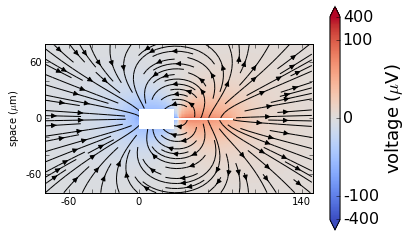

In [8]:
import matplotlib.pylab as plt
%matplotlib inline

# draw extracellular field at the given timept (plot_at_time)
plt.figure()
ax = plt.subplot(1,1,1)
mycmap, colormap_range_ceil, aspect, one_forth_colormap,colormap_range = helper_provide_imshow_details(v_ext, x_range, y_range)
pcm = plt.imshow(v_ext[idx_to_plot,:,:], interpolation="nearest",
                     norm=colors.SymLogNorm(linthresh=0.01 * np.max(v_ext),
                                            linscale = 1.0,
                                            vmin=colormap_range_ceil[0], vmax=colormap_range_ceil[1]),
        origin='lower',
         aspect=aspect,
        extent=(x_range[0], x_range[1], y_range[0], y_range[1]),
                     cmap = mycmap)

x_tic_label, xtics, y_tic_label, ytics = helper_define_tick_space(x_range, y_range)
ax.set_yticks(ytics)
ax.set_yticklabels(y_tic_label)
ax.set_xticks(xtics)
ax.set_xticklabels(x_tic_label)

plt.ylabel(r"space ($\mu$m)")
cbar = plt.colorbar(pcm,  extend='both', drawedges = False) #ax=ax[0],

cbar.set_ticks([colormap_range[0],-one_forth_colormap, 0, one_forth_colormap, colormap_range[1]])
cbar.set_ticklabels([str(colormap_range[0]),str(-one_forth_colormap),'0',str(one_forth_colormap),colormap_range[1]])

cbar.set_label(r"voltage ($\mu$V)", fontsize = 18)
cbar.ax.tick_params(labelsize = 16)

min_soma_x = min(seg_coords[seg_coords['name'] == 'soma']['x0'])
max_soma_x = max(seg_coords[seg_coords['name'] == 'soma']['x1'])
diam_soma = seg_coords[seg_coords['name'] == 'soma']['diam'][0]
min_axon_x = min(seg_coords[seg_coords['name'] == 'axon']['x0'])
max_axon_x = max(seg_coords[seg_coords['name'] == 'axon']['x1'])
diam_axon = seg_coords[seg_coords['name'] == 'axon']['diam'][0]

# draw streamplot (arrows)
U = -np.diff(v_ext[idx_to_plot, :, :], axis=0)[:, :-1]
V = -np.diff(v_ext[idx_to_plot, : ,:], axis=1)[:-1, :]
U[min_soma_x:max_soma_x, -0.5*diam_soma:0.5*diam_soma] = 0
V[min_soma_x:max_soma_x, -0.5*diam_soma:0.5*diam_soma] = 0
    
plt.streamplot(xx[0, :-1], yy[:-1, 0], V, U, density = 1.0, color = 'k')

# plot shape of the neuron
draw_neuron_shape(diam_soma, min_soma_x, max_soma_x,
                      diam_axon, min_axon_x, max_axon_x,
                      init_spike_axon_dist=np.nan)

timeline = np.arange(0,(len(v_memb_axon))*h.dt-1e-10, h.dt)

/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/maja/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


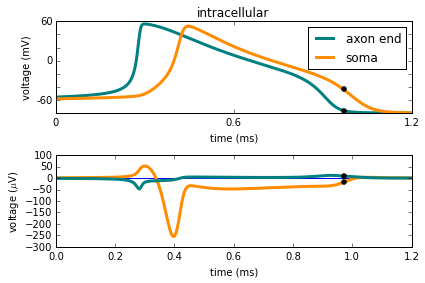

In [9]:
# action potential
# intracellular ap in the soma and in the axon
plt.figure()
ax0 = plt.subplot(2,1,1)
plt.plot(timeline, v_memb_axon, color = axon_color, label='axon end', lw = 3)
plt.plot(timeline, v_memb_soma, color = soma_color, label = 'soma', lw = 3)
plt.plot(timeline[idx_to_plot], v_memb_soma[idx_to_plot], 'o', color = 'k', ms = 5)
plt.plot(timeline[idx_to_plot], v_memb_axon[idx_to_plot], 'o', color = 'k', ms = 5)

start_timeline = 0 #min(timeline)
end_timeline = np.round(timeline[-1],2) #x_range[1]
middle_timeline = np.round(np.mean([start_timeline,end_timeline]),2)

ax0.set_xticks([start_timeline, middle_timeline, end_timeline])
ax0.set_xticklabels([str(start_timeline), str(middle_timeline), str(end_timeline)])
ax0.set_yticks([-80, -60, -40, -20, 0, 20, 40, 60])
ax0.set_yticklabels(['', '-60', '', '', '0', '', '', '60'])
plt.xlim([start_timeline, end_timeline])
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')
plt.legend()
plt.title('intracellular')

# external spike in the given location
plt.subplot(2,1,2)

sp_loc_x = [min_axon_x, max_axon_x]
sp_loc_y = [1+0.5*diam_axon, 1+0.5*diam_axon]

v_ext_spike = field.estimate_on_grid(seg_coords, I,
                               np.array([sp_loc_x]),
                                np.array([sp_loc_y])
                                              )


plt.axhline(0)

plt.plot(timeline, v_ext_spike[:, 0, 0]/1e3,color=soma_color,lw=3,label='near soma')
plt.plot(timeline, v_ext_spike[:, 0, 1]/1e3,color=axon_color,lw=3,label='near axon')
plt.plot(timeline[idx_to_plot], v_ext_spike[idx_to_plot,0,0]/1e3, 'o', color = 'k', ms = 5)
plt.plot(timeline[idx_to_plot], v_ext_spike[idx_to_plot,0,1]/1e3, 'o', color = 'k', ms = 5)

plt.ylabel(r'voltage ($\mu$V)')
plt.xlabel('time (ms)')
plt.tight_layout()